In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pylab as plt
import numpy as np

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else "cpu"

In [5]:
def gen_data(N=100, d=10, low=0, high=10, target_idx=3):
    data = np.random.randint(low=low, high=high, size=(N,d))
    return data, data[:, target_idx]

In [7]:
N = 5000
train_data, train_target = gen_data(N=N)
test_data, test_target = gen_data(N=N)

Input array: a

Fixed index: i

Experiment 1: Always predict entry in fixed index position: a $\rightarrow$ a[i] #current PC

Experiment 1a: Experiment 1 with i as an input

Experiment 2: a $\rightarrow$ a[target_idx + a[i]] #going to correct instruction location - offset

Experiment 3: conditional on a[target_idx + a[i]] #increment to next PC

## Experiment 1

In [117]:
d = 10 #length of generated arrays
low = 0 #values in array, v satisfy low <= v <= high-1 
high = 10 #values in array, v satisfy low <= v <= high-1
n_hidden = 10 #if net is MLP, number of hidden nodes (with 1 hidden layer)
target_idx = 3 #target is array[target_idx]

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [118]:
net(torch.from_numpy(train_data[0:5]).float()).shape

torch.Size([5, 10])

In [119]:
N_epochs = 10000

def validate(net, test_data, test_target, net_type=None):
    net = net.eval()
    
    with torch.no_grad():
        test_data_torch = torch.from_numpy(test_data).float().to(device)
        test_target_torch = torch.from_numpy(test_target).float().to(device)

        if net_type=='conv':
            test_data_torch = test_data_torch.unsqueeze(1).unsqueeze(2)
        
        test_pred = net(test_data_torch).argmax(dim=1)
        test_accuracy = (test_target_torch == test_pred).float().mean().to('cpu').detach().numpy()

        test_rmse = ((test_pred-test_target_torch)**2).mean().sqrt().to('cpu').detach().numpy()

    return test_accuracy, test_rmse

def train_net(net, train_data, train_target, test_data, test_target, N_epochs=10, print_freq=100, net_type=None):
    net = net.to(device)
    train_data_torch = torch.from_numpy(train_data).float().to(device)
    train_target_torch = torch.from_numpy(train_target).to(device)
    
    if net_type=='conv':
        train_data_torch = train_data_torch.unsqueeze(1).unsqueeze(2)
    
    net = net.train()
    for i in range(N_epochs):
        pred = net(train_data_torch)
        loss = criterion(pred, train_target_torch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % print_freq == 0:
            train_accuracy, train_rmse = validate(net, train_data, train_target, net_type=net_type)
            test_accuracy, test_rmse = validate(net, test_data, test_target, net_type=net_type)
            net = net.train()
            print(f'Epoch = {i} loss={loss} train_acc = {train_accuracy:.3f} test_acc = {test_accuracy:.3f} train_rmse = {train_rmse:.3f}  test_rmse = {test_rmse:.3f}')
            
    return net

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=1000, print_freq=10)

Epoch = 0 loss=2.937025308609009 train_acc = 0.101 test_acc = 0.109 train_rmse = 3.154  test_rmse = 3.090
Epoch = 10 loss=2.3081398010253906 train_acc = 0.146 test_acc = 0.142 train_rmse = 3.994  test_rmse = 4.000
Epoch = 20 loss=2.0940351486206055 train_acc = 0.229 test_acc = 0.226 train_rmse = 2.645  test_rmse = 2.597
Epoch = 30 loss=1.821569561958313 train_acc = 0.275 test_acc = 0.268 train_rmse = 1.745  test_rmse = 1.748
Epoch = 40 loss=1.6072783470153809 train_acc = 0.367 test_acc = 0.359 train_rmse = 1.218  test_rmse = 1.214
Epoch = 50 loss=1.445681095123291 train_acc = 0.434 test_acc = 0.437 train_rmse = 1.049  test_rmse = 1.045
Epoch = 60 loss=1.3340387344360352 train_acc = 0.503 test_acc = 0.507 train_rmse = 0.964  test_rmse = 0.953
Epoch = 70 loss=1.2497198581695557 train_acc = 0.552 test_acc = 0.539 train_rmse = 0.937  test_rmse = 0.936
Epoch = 80 loss=1.1837598085403442 train_acc = 0.590 test_acc = 0.573 train_rmse = 0.901  test_rmse = 0.900
Epoch = 90 loss=1.12921524047851

Epoch = 840 loss=0.047099530696868896 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.028
Epoch = 850 loss=0.04572710767388344 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.028
Epoch = 860 loss=0.04420098289847374 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.028
Epoch = 870 loss=0.04291915148496628 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.028
Epoch = 880 loss=0.04126940295100212 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.028
Epoch = 890 loss=0.03976451978087425 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.028
Epoch = 900 loss=0.038608066737651825 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.028
Epoch = 910 loss=0.03737329691648483 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.024
Epoch = 920 loss=0.03621530905365944 train_acc = 1.000 test_acc = 0.999 train_rmse = 0.014  test_rmse = 0.024
Epoch = 

In [195]:
#weights are not "peaky"

for _ in range(n_hidden):
    l = list(net.parameters())[0][_]
    
    print('---')
    print(l)
    print(l[target_idx].abs() / l.abs().min())
    
print('***')
for _ in range(high-low):
    l = list(net.parameters())[2][_]
    
    print('---')
    print(l)
    
    print(l[target_idx].abs() / l.abs().min())

---
tensor([-0.3015,  0.1111,  0.2111, -0.3045, -0.2890,  0.0473, -0.1259, -0.2070,
        -0.2045, -0.3144], grad_fn=<SelectBackward0>)
tensor(6.4355, grad_fn=<DivBackward0>)
---
tensor([ 0.0667, -0.1944,  0.0216,  0.1067,  0.1495, -0.0623,  0.2018, -0.1545,
        -0.0649, -0.3151], grad_fn=<SelectBackward0>)
tensor(4.9419, grad_fn=<DivBackward0>)
---
tensor([ 0.1088,  0.2854, -0.2113,  0.0557, -0.1331,  0.2542, -0.0837,  0.1790,
         0.3101,  0.0939], grad_fn=<SelectBackward0>)
tensor(1., grad_fn=<DivBackward0>)
---
tensor([-0.0322,  0.2941,  0.1110, -0.1791,  0.2127,  0.1184, -0.1106,  0.2899,
         0.2439,  0.0996], grad_fn=<SelectBackward0>)
tensor(5.5586, grad_fn=<DivBackward0>)
---
tensor([ 0.3080, -0.1598, -0.3045, -0.2603,  0.1060, -0.0187,  0.2244, -0.0984,
         0.1602,  0.2788], grad_fn=<SelectBackward0>)
tensor(13.8863, grad_fn=<DivBackward0>)
---
tensor([ 0.0815,  0.1844, -0.1693,  0.0600, -0.2865,  0.0814, -0.0856,  0.0808,
        -0.2522, -0.0682], grad_fn

In [196]:
list(net.parameters())[0].sum(dim=0)

tensor([ 0.1752,  0.3209, -0.4630, -0.7688, -0.1848,  0.3138,  0.4108,  0.3876,
        -0.3857, -0.0603], grad_fn=<SumBackward1>)

In [197]:
list(net.parameters())[0].sum(dim=1)

tensor([-1.3773, -0.2450,  0.8590,  1.0475,  0.2358, -0.3738,  0.2014, -0.5981,
         0.0190, -0.0229], grad_fn=<SumBackward1>)

In [198]:
test_data_torch[2]

tensor([ 8., 17.,  9., 17.,  4., 15., 11., 17.,  7., 12.], device='cuda:0')

In [199]:
np.matmul(np.array(list(net.parameters())[0].cpu().detach()), test_data[2]) + np.array(list(net.parameters())[1].cpu().detach())

array([-5.469349  ,  0.64563804,  3.7054089 ,  4.40810317,  2.95738274,
       -0.04907821,  2.83234672, -1.58928016,  0.44751332,  0.03399417])

### Experiments 1X:

1a. what happens when number of hidden nodes is decreased from 20?

1b. 2d (t-sne) visualizations

    raw data -> t-sne (colors are the target value)
    
    raw data -> nn -> take the activations (20 intermediate values) -> t-sne (colors are the target value)
    
1c. interpreting nns: which input element has the most effect on the output

1d. paths from each input node to each output node

1e. compute derivatives of output nodes w.r.t. input nodes and look at max absolute value

1f. replace net by convolutional net and check weights

1g. try more hidden layers

1h. try attention

### Experiment 1a: vary n_hidden

In [212]:
n_hidden = 1

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=2.6532723903656006 train_acc = 0.103 test_acc = 0.091 train_rmse = 3.908  test_rmse = 3.926
Epoch = 1000 loss=1.1496717929840088 train_acc = 0.611 test_acc = 0.605 train_rmse = 0.984  test_rmse = 1.000
Epoch = 2000 loss=0.8222751021385193 train_acc = 0.799 test_acc = 0.789 train_rmse = 0.713  test_rmse = 0.726
Epoch = 3000 loss=0.6934895515441895 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 4000 loss=0.6076760292053223 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 5000 loss=0.5427573919296265 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 6000 loss=0.4914427101612091 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 7000 loss=0.45086073875427246 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 8000 loss=0.41952523589134216 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 900

In [214]:
n_hidden = 2

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=2.644395112991333 train_acc = 0.105 test_acc = 0.091 train_rmse = 3.576  test_rmse = 3.651
Epoch = 1000 loss=0.990158200263977 train_acc = 0.703 test_acc = 0.701 train_rmse = 0.778  test_rmse = 0.784
Epoch = 2000 loss=0.7899806499481201 train_acc = 0.803 test_acc = 0.793 train_rmse = 0.710  test_rmse = 0.721
Epoch = 3000 loss=0.6769148707389832 train_acc = 0.803 test_acc = 0.794 train_rmse = 0.710  test_rmse = 0.721
Epoch = 4000 loss=0.5960864424705505 train_acc = 0.803 test_acc = 0.793 train_rmse = 0.710  test_rmse = 0.723
Epoch = 5000 loss=0.5335060358047485 train_acc = 0.803 test_acc = 0.793 train_rmse = 0.710  test_rmse = 0.723
Epoch = 6000 loss=0.4838044345378876 train_acc = 0.803 test_acc = 0.793 train_rmse = 0.710  test_rmse = 0.723
Epoch = 7000 loss=0.4445449113845825 train_acc = 0.803 test_acc = 0.793 train_rmse = 0.710  test_rmse = 0.723
Epoch = 8000 loss=0.41438260674476624 train_acc = 0.803 test_acc = 0.793 train_rmse = 0.710  test_rmse = 0.723
Epoch = 9000 l

In [216]:
n_hidden = 3

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=2.5127551555633545 train_acc = 0.064 test_acc = 0.062 train_rmse = 4.560  test_rmse = 4.553
Epoch = 1000 loss=1.1365019083023071 train_acc = 0.611 test_acc = 0.605 train_rmse = 0.834  test_rmse = 0.844
Epoch = 2000 loss=0.7987487316131592 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 3000 loss=0.6724029779434204 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 4000 loss=0.5889480710029602 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 5000 loss=0.5264238715171814 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 6000 loss=0.4775548279285431 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 7000 loss=0.43960732221603394 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 8000 loss=0.41086357831954956 train_acc = 0.801 test_acc = 0.793 train_rmse = 0.711  test_rmse = 0.723
Epoch = 900

In [215]:
n_hidden = 4

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=2.3994696140289307 train_acc = 0.097 test_acc = 0.103 train_rmse = 5.352  test_rmse = 5.375
Epoch = 1000 loss=0.16526924073696136 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 2000 loss=0.03721220791339874 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 3000 loss=0.014808270148932934 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 4000 loss=0.007174258586019278 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 5000 loss=0.0038195305969566107 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 6000 loss=0.002136622089892626 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 7000 loss=0.0012317924993112683 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 8000 loss=0.0007227032911032438 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.

### Question for experiment 1a: why is n_hidden=4 where a sudden transition in performance takes place? Is it related to target_idx=3?

In [221]:
N = 5000
train_data, train_target = gen_data(N=N, target_idx=6)
test_data, test_target = gen_data(N=N, target_idx=6)

In [226]:
n_hidden = 1

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=2.772714376449585 train_acc = 0.095 test_acc = 0.091 train_rmse = 4.494  test_rmse = 4.515
Epoch = 1000 loss=2.301755905151367 train_acc = 0.106 test_acc = 0.096 train_rmse = 4.540  test_rmse = 4.522
Epoch = 2000 loss=2.301205635070801 train_acc = 0.107 test_acc = 0.096 train_rmse = 4.536  test_rmse = 4.517
Epoch = 3000 loss=2.2999746799468994 train_acc = 0.107 test_acc = 0.097 train_rmse = 4.520  test_rmse = 4.502
Epoch = 4000 loss=0.8183386325836182 train_acc = 0.796 test_acc = 0.781 train_rmse = 0.452  test_rmse = 0.468
Epoch = 5000 loss=0.6665934324264526 train_acc = 0.809 test_acc = 0.794 train_rmse = 0.437  test_rmse = 0.454
Epoch = 6000 loss=0.5768826007843018 train_acc = 0.809 test_acc = 0.794 train_rmse = 0.437  test_rmse = 0.454
Epoch = 7000 loss=0.5124085545539856 train_acc = 0.809 test_acc = 0.794 train_rmse = 0.437  test_rmse = 0.454
Epoch = 8000 loss=0.46353697776794434 train_acc = 0.809 test_acc = 0.794 train_rmse = 0.437  test_rmse = 0.454
Epoch = 9000 lo

In [230]:
n_hidden = 2

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=3.048898696899414 train_acc = 0.104 test_acc = 0.119 train_rmse = 3.477  test_rmse = 3.484
Epoch = 1000 loss=1.1101036071777344 train_acc = 0.609 test_acc = 0.584 train_rmse = 0.837  test_rmse = 0.846
Epoch = 2000 loss=0.4700790047645569 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 3000 loss=0.23210586607456207 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 4000 loss=0.1511794626712799 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 5000 loss=0.10203485190868378 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 6000 loss=0.06872177869081497 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 7000 loss=0.04601314291357994 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 8000 loss=0.030869195237755775 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 

In [228]:
n_hidden = 3

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=2.9217448234558105 train_acc = 0.126 test_acc = 0.116 train_rmse = 4.126  test_rmse = 4.136
Epoch = 1000 loss=0.12990738451480865 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.060  test_rmse = 0.014
Epoch = 2000 loss=0.017265046015381813 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.014
Epoch = 3000 loss=0.005189168732613325 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 4000 loss=0.0021064416505396366 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 5000 loss=0.0009787054732441902 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 6000 loss=0.0004875070007983595 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 7000 loss=0.00025403936160728335 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 8000 loss=0.0001347991346847266 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse 

In [227]:
n_hidden = 4

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=2.7339725494384766 train_acc = 0.119 test_acc = 0.110 train_rmse = 4.634  test_rmse = 4.647
Epoch = 1000 loss=0.14368084073066711 train_acc = 0.999 test_acc = 1.000 train_rmse = 0.028  test_rmse = 0.000
Epoch = 2000 loss=0.01617692969739437 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.014  test_rmse = 0.000
Epoch = 3000 loss=0.004698417615145445 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 4000 loss=0.0018843208672478795 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 5000 loss=0.0008788132690824568 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 6000 loss=0.0004434954607859254 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 7000 loss=0.00023419401259161532 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 8000 loss=0.00012716562196146697 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse 

### Note: When target_idx was changed to 6, even n_hidden=2 worked well (in terms of performance on test set). Why?

Plot 1: Plot input vectors
* Input vectors are 10d
* Use t-sne to map it to 2d and plot. Color each point by the target value

Plot 2: Plot hidden activations (n_hidden=2 or n_hidden=3)
* Plot hidden layer activations for each input vector and color them by the target value

In [233]:
n_hidden = 2

net = nn.Sequential(nn.Linear(d, n_hidden),
                    nn.ReLU(),
                    nn.Linear(n_hidden, high-low))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=10000, print_freq=1000)

Epoch = 0 loss=3.2268967628479004 train_acc = 0.108 test_acc = 0.103 train_rmse = 4.337  test_rmse = 4.337
Epoch = 1000 loss=1.109921932220459 train_acc = 0.609 test_acc = 0.587 train_rmse = 0.836  test_rmse = 0.844
Epoch = 2000 loss=0.9139060378074646 train_acc = 0.706 test_acc = 0.694 train_rmse = 0.776  test_rmse = 0.777
Epoch = 3000 loss=0.2796461880207062 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 4000 loss=0.16456685960292816 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 5000 loss=0.11058631539344788 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 6000 loss=0.07540344446897507 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 7000 loss=0.051220472902059555 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 8000 loss=0.03460615873336792 train_acc = 1.000 test_acc = 1.000 train_rmse = 0.000  test_rmse = 0.000
Epoch = 

In [235]:
net(torch.from_numpy(train_data[0]).float().to(device))

tensor([ 142.4816,  138.6892,  127.0850,  105.7965,   71.8712,   13.4982,
        -754.4501, -165.0163, -167.9870, -192.0000], device='cuda:0',
       grad_fn=<AddBackward0>)

In [245]:
params = list(net.parameters())
act = nn.ReLU()

In [250]:
layer1_act = torch.matmul(params[0], torch.from_numpy(train_data[0]).float().to(device)) + params[1]

layer1_act_relu = act(layer1_act)

In [251]:
out_act = torch.matmul(params[2], layer1_act_relu) + params[3]

In [252]:
out_act

tensor([ 142.4816,  138.6892,  127.0850,  105.7965,   71.8712,   13.4982,
        -754.4501, -165.0163, -167.9870, -192.0000], device='cuda:0',
       grad_fn=<AddBackward0>)

In [253]:
layer1_act

tensor([ 18.6105, -14.9387], device='cuda:0', grad_fn=<AddBackward0>)

In [257]:
layer1_act = torch.matmul(torch.from_numpy(train_data).float().to(device), params[0].T) + params[1]

In [261]:
layer1_act = layer1_act.cpu().detach().numpy()

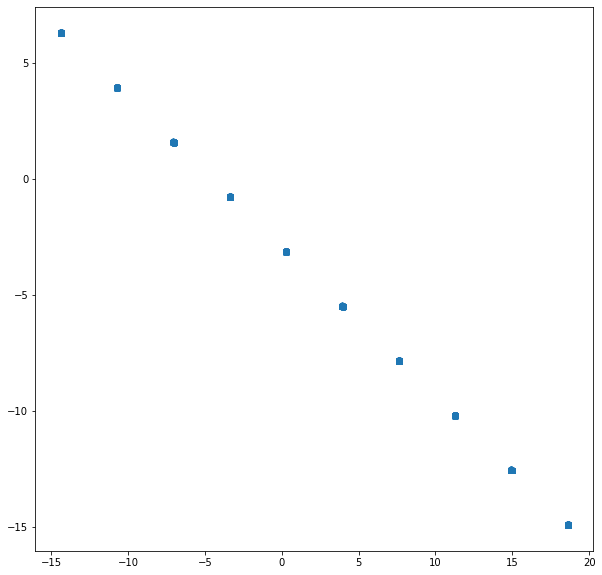

In [267]:
plt.figure(figsize=(10,10))
plt.plot(layer1_act[:,0], layer1_act[:,1], 'p')

#### Experiment 1g: Convolutional net for indexing: a -> a[i]

In [120]:
d = 10 #length of generated arrays
low = 0 #values in array, v satisfy low <= v <= high-1 
high = 10 #values in array, v satisfy low <= v <= high-1
n_hidden = 10 #if net is MLP, number of hidden nodes (with 1 hidden layer)
target_idx = 3 #target is array[target_idx]

net = nn.Sequential(nn.Conv2d(1, 8, kernel_size=(1,3), stride=1),
                    nn.ReLU(),
                    nn.Conv2d(8, 16, kernel_size=(1,3), stride=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 32, kernel_size=(1,3), stride=1),
                    nn.ReLU(),
                    nn.Flatten(start_dim=1, end_dim=-1),
                    nn.Linear(128, high-low) #output layer: stays the same
                   )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

net = train_net(net, train_data, train_target, test_data, test_target, N_epochs=200, print_freq=10, net_type='conv')

Epoch = 0 loss=2.310180187225342 train_acc = 0.134 test_acc = 0.129 train_rmse = 4.250  test_rmse = 4.230
Epoch = 10 loss=1.6137149333953857 train_acc = 0.348 test_acc = 0.325 train_rmse = 1.403  test_rmse = 1.440
Epoch = 20 loss=1.2371515035629272 train_acc = 0.418 test_acc = 0.403 train_rmse = 1.006  test_rmse = 1.010
Epoch = 30 loss=1.0202583074569702 train_acc = 0.578 test_acc = 0.554 train_rmse = 0.785  test_rmse = 0.809
Epoch = 40 loss=0.891410231590271 train_acc = 0.630 test_acc = 0.614 train_rmse = 0.770  test_rmse = 0.781
Epoch = 50 loss=0.8740519285202026 train_acc = 0.663 test_acc = 0.640 train_rmse = 0.622  test_rmse = 0.638
Epoch = 60 loss=0.6517972946166992 train_acc = 0.756 test_acc = 0.734 train_rmse = 0.505  test_rmse = 0.525
Epoch = 70 loss=0.499099463224411 train_acc = 0.877 test_acc = 0.857 train_rmse = 0.351  test_rmse = 0.378
Epoch = 80 loss=0.5972312092781067 train_acc = 0.678 test_acc = 0.662 train_rmse = 0.653  test_rmse = 0.681
Epoch = 90 loss=0.47381529211997

##### Interpreting conv filters

In [121]:
train_data_torch = torch.from_numpy(train_data).float()
train_target_torch = torch.from_numpy(train_target)

In [126]:
net(train_data_torch[[0]].unsqueeze(1).unsqueeze(2).to(device))

tensor([[-257.4438, -167.5562,  -96.5393,  -48.5901,  -15.3641,    4.1092,
           15.8687,   25.2410,   28.5121,   26.6456]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

array([[ 0.4551936 , -0.2917346 , -0.35919452],
       [ 0.20683491,  0.3013565 ,  0.36513108],
       [ 0.5832914 ,  0.15777262,  0.01081634],
       [-0.31274712,  0.52892417, -0.25362423],
       [-0.08488885, -0.03802393,  0.00662402],
       [ 0.03717137,  0.62884265,  0.05331021],
       [ 0.455009  ,  0.9706499 , -0.16476205],
       [ 0.9354688 , -0.07806922,  0.00116902]], dtype=float32)

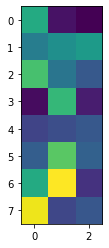

In [174]:
plt.imshow(list(list(net.named_children())[0][1].parameters())[0].squeeze(1).squeeze(1).to('cpu').detach().numpy())
list(list(net.named_children())[0][1].parameters())[0].squeeze(1).squeeze(1).to('cpu').detach().numpy()

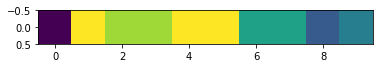

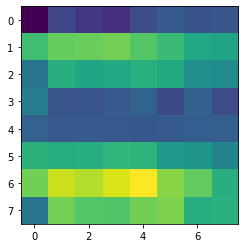

In [153]:
x = train_data_torch[[0]].unsqueeze(1).unsqueeze(2).to(device)
img0 = x.squeeze(1).squeeze(2).squeeze(0).to('cpu').detach().numpy()
plt.imshow(img0)

plt.figure()
x = list(net.named_children())[0][1](x)
img1 = x.squeeze(1).squeeze(2).squeeze(0).to('cpu').detach().numpy()
plt.imshow(img1)



In [151]:
list(net.named_children())

[('0', Conv2d(1, 8, kernel_size=(1, 3), stride=(1, 1))),
 ('1', ReLU()),
 ('2', Conv2d(8, 16, kernel_size=(1, 3), stride=(1, 1))),
 ('3', ReLU()),
 ('4', Conv2d(16, 32, kernel_size=(1, 3), stride=(1, 1))),
 ('5', ReLU()),
 ('6', Flatten(start_dim=1, end_dim=-1)),
 ('7', Linear(in_features=128, out_features=10, bias=True))]